In [1]:
import torch
import torch.fft
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from dataprocess.sirst import IRSTD1kDataset
import torch.utils.data as Data
import yaml

cfg_path = 'cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

In [3]:
trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=256, cfg=cfg)
train_data_loader = Data.DataLoader(trainset, batch_size=8, shuffle=False)

In [ ]:
def gradient(image_batch):
    # 定义 Sobel 算子
    sobel = torch.tensor([[[[-1., 0., 1.],
                            [-2., 0., 2.],
                            [-1., 0., 1.]]],
                          [[[ 1., 2., 1.],
                            [ 0., 0., 0.],
                            [-1.,-2.,-1.]]],
                          [[[ 2., 1., 0.],
                            [ 1., 0.,-1.],
                            [ 0.,-1.,-2.]]],
                          [[[ 0., 1., 2.],
                            [-1., 0., 1.],
                            [-2.,-1., 0.]]]], dtype=image_batch.dtype, device=image_batch.device)
    # 找到四个方向上最大的梯度
    _gradient = F.conv2d(image_batch, sobel, padding=1)  # (B, 4, S, S)
    _gradient = torch.max(torch.abs(_gradient), dim=1, keepdim=True).values
    _gradient[:, :, 0, :] = 0
    _gradient[:, :, -1,:] = 0
    _gradient[:, :, :, 0] = 0
    _gradient[:, :, :,-1] = 0
    return _gradient

def gradient_optim(gradient): 
    b, c, s, _ = gradient.shape
    kernnel_size = 64
    max_num = F.max_pool2d(gradient, kernnel_size, kernnel_size//2, kernnel_size//2)
    min_num = - F.max_pool2d(-gradient, kernnel_size, kernnel_size//2, kernnel_size//2)
    max_num = F.interpolate(max_num, scale_factor=int(kernnel_size//2))
    min_num = F.interpolate(min_num, scale_factor=int(kernnel_size//2))
    max_num = max_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]
    min_num = min_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]
    gradient = torch.where(max_num-min_num > 0.5, gradient, torch.zeros_like(gradient))
    # mean_num = torch.mean((max_num-min_num).view(b,c,s*s), dim=2)
    # avg_num = F.avg_pool2d(gradient, 3, 1, 1)
    _gradient = (gradient-min_num)/(max_num-min_num)
    return torch.where(_gradient>0.6, torch.ones_like(_gradient), torch.zeros_like(_gradient))

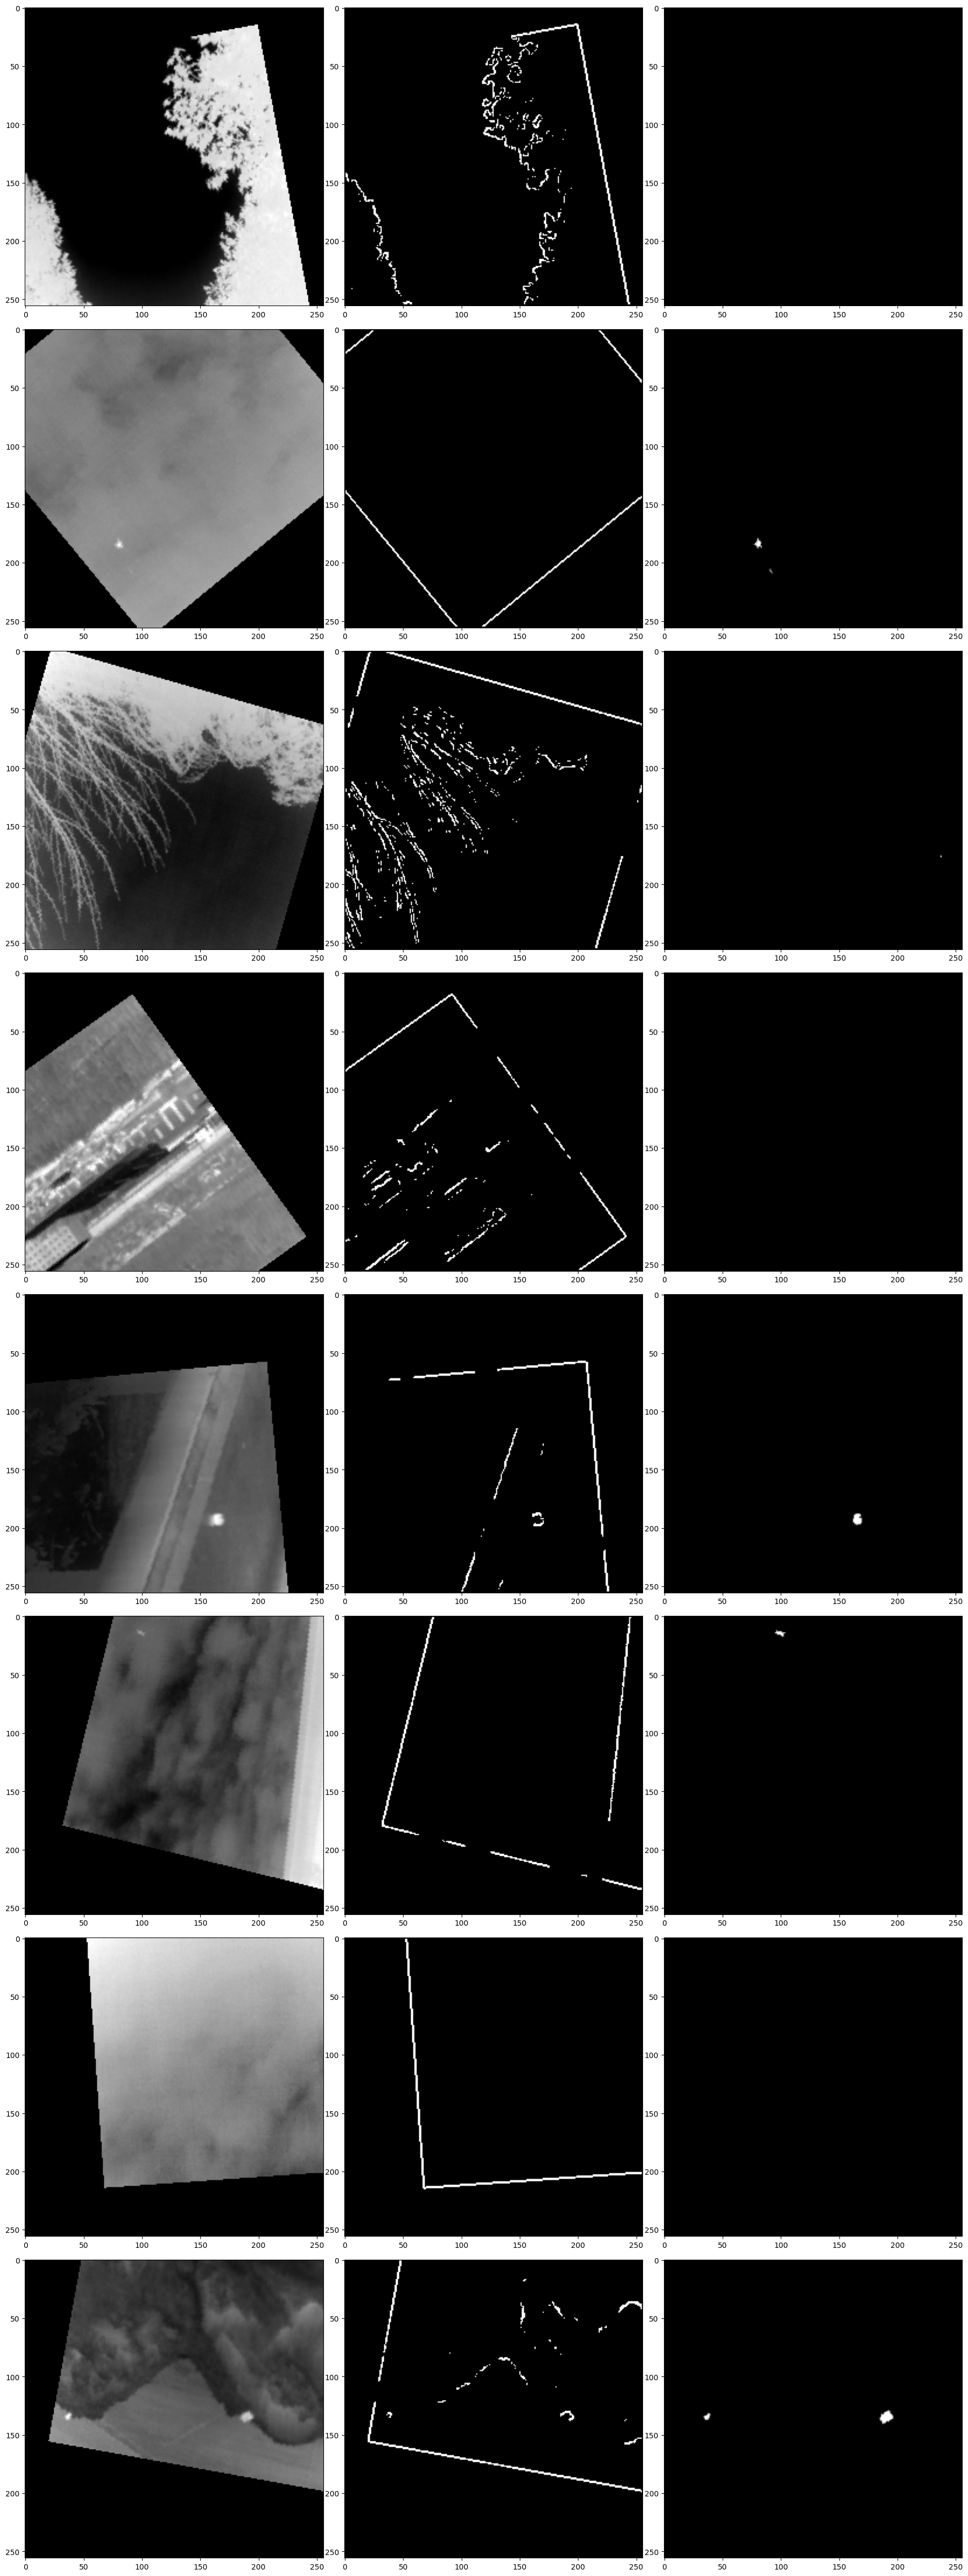

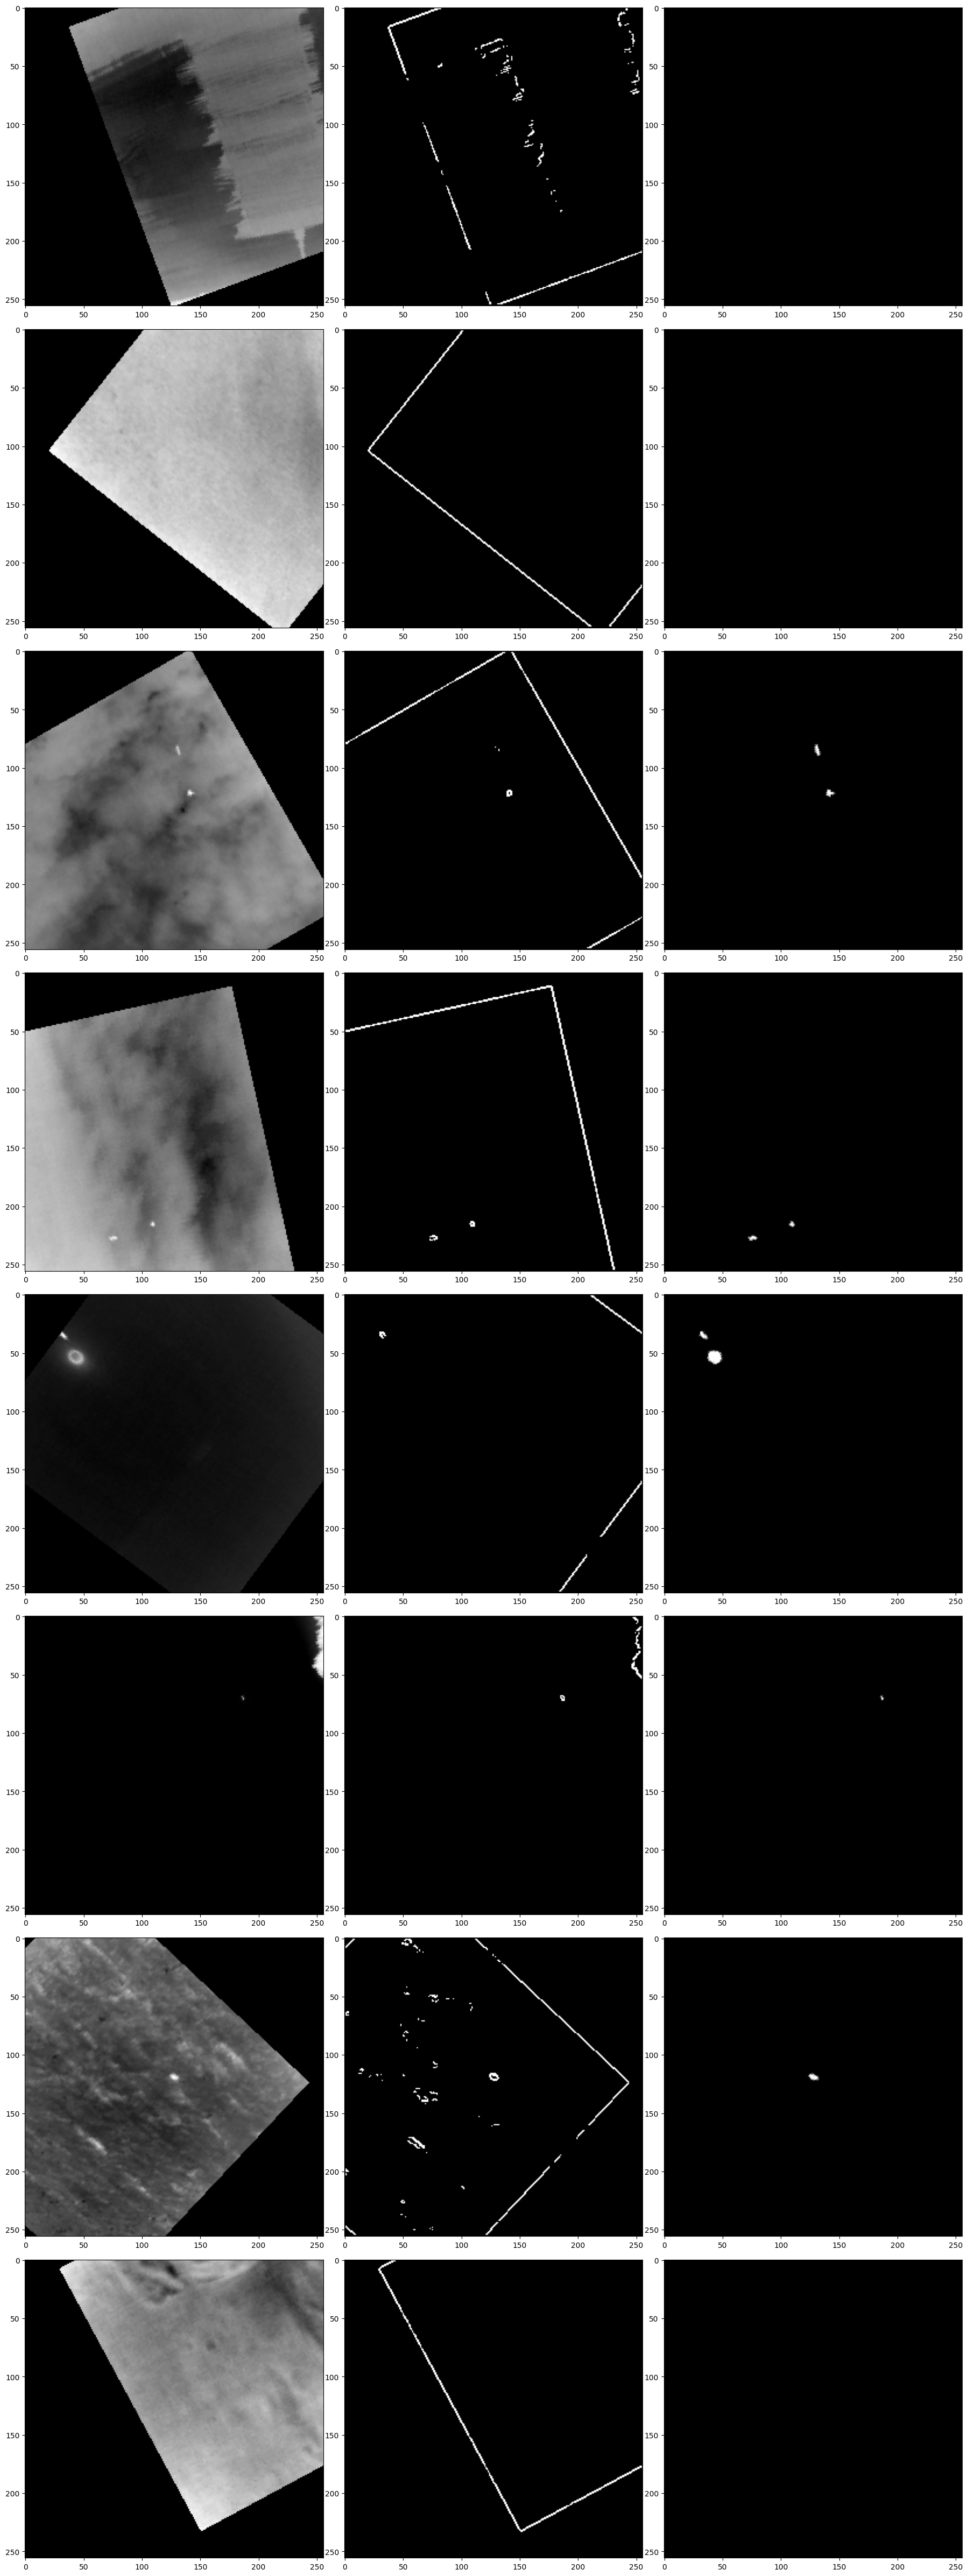

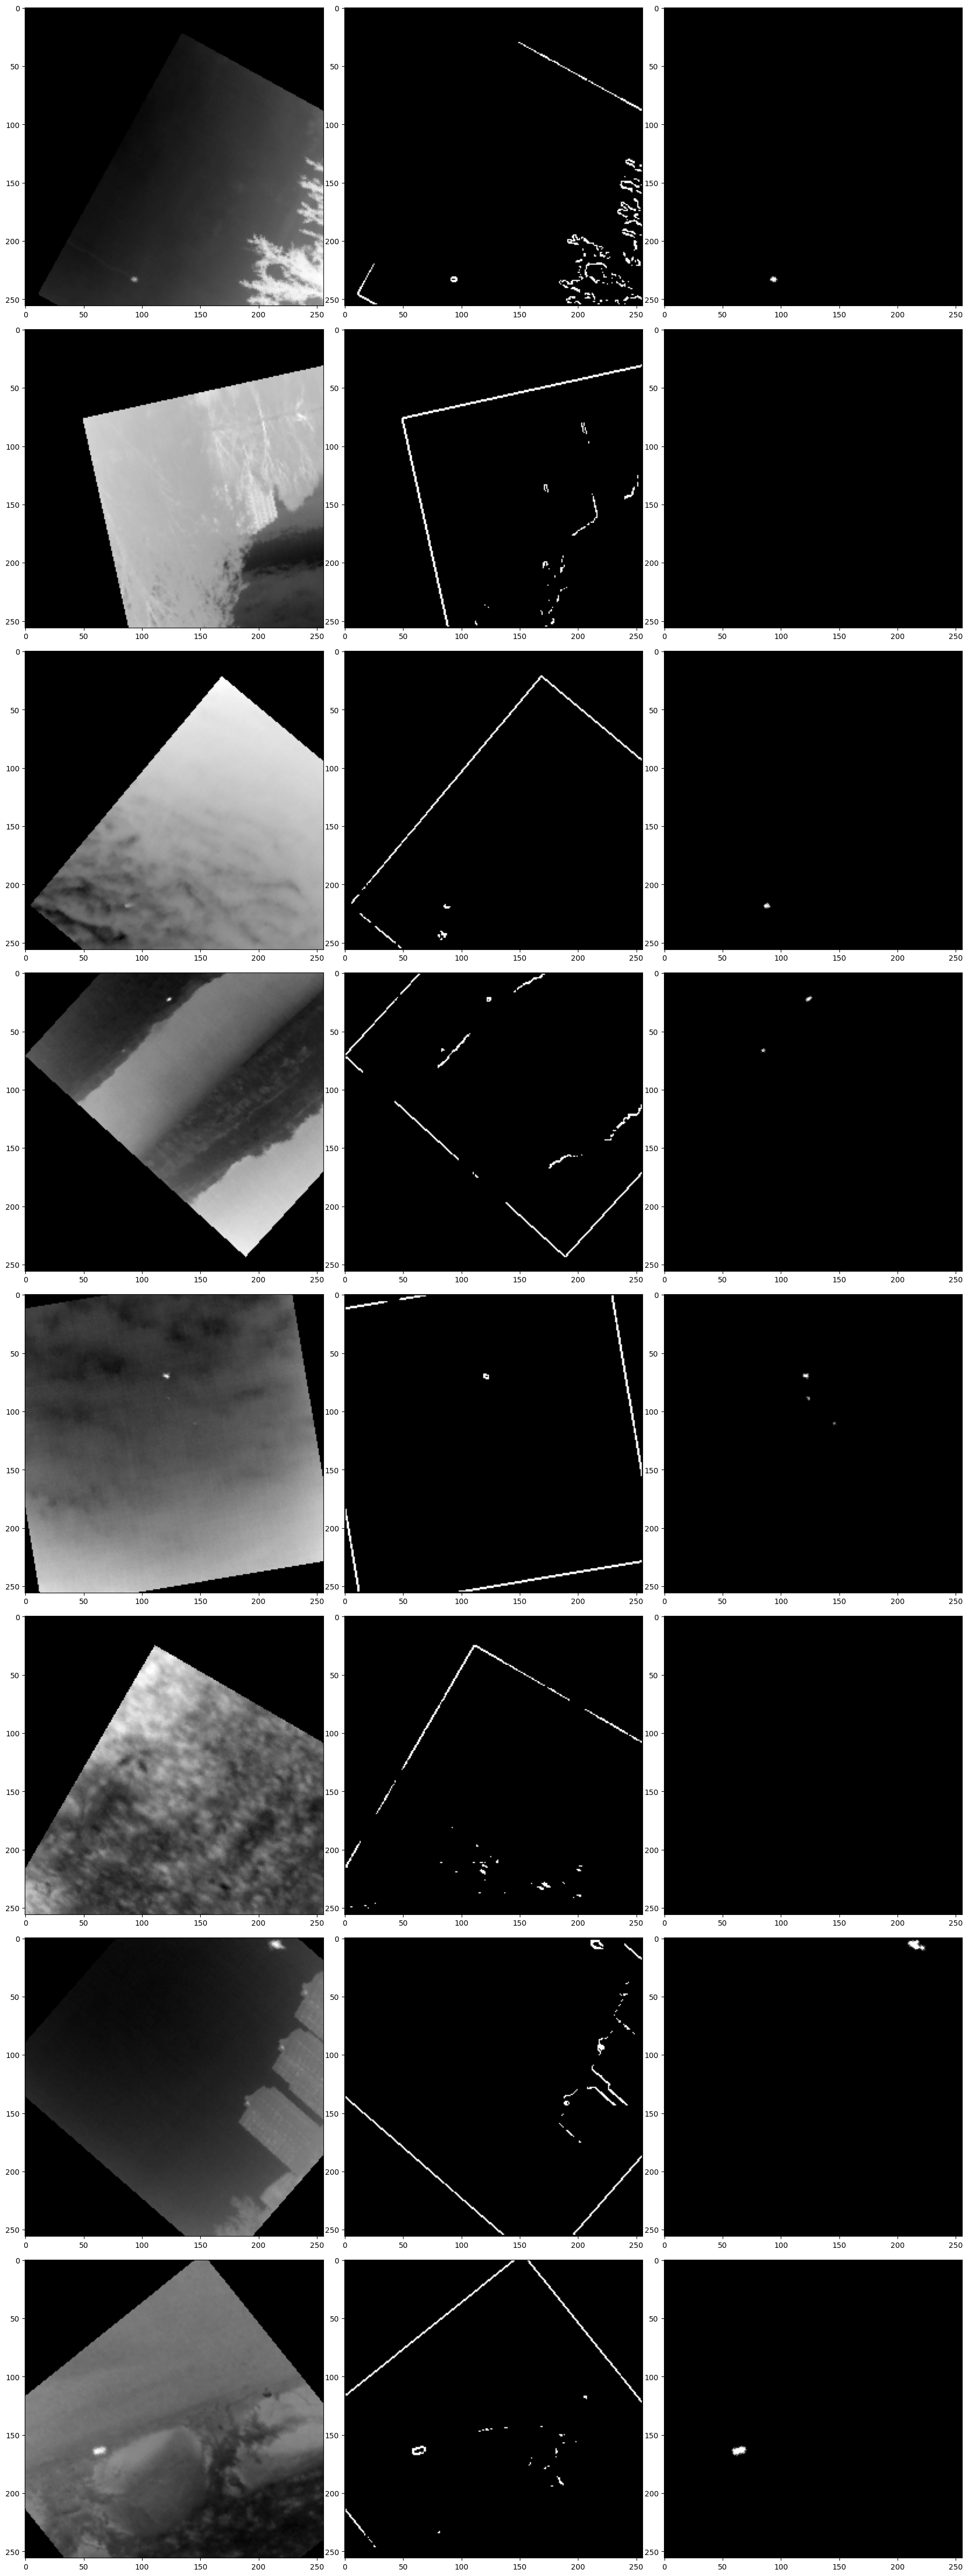

KeyboardInterrupt: 

In [ ]:
for j, (data, label) in enumerate(train_data_loader):
    img_gradient = gradient(data)
    img_gradient = gradient_optim(img_gradient)
    row_num = label.shape[0]
    fig, axes = plt.subplots(row_num, 3, figsize=(3*6, row_num*6))
    for i in range(row_num):
        axes[i, 0].imshow(data[i,0], cmap='gray')
        axes[i, 1].imshow(img_gradient[i,0], cmap='gray')
        axes[i, 2].imshow(label[i,0], cmap='gray')
    plt.tight_layout()
    plt.show()
    a = input()

In [2]:
# 读取图像并转换为Tensor
image_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images/000491.png"  # 替换为你的图片路径
image = Image.open(image_path).convert('L')  # 转换为灰度图
transform = transforms.ToTensor()
tensor_image = transform(image)

# 将Tensor转换到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_image = tensor_image.to(device)

In [31]:
img_gradient = gradient(tensor_image.unsqueeze(0))
img_gradient = gradient_optim(img_gradient)

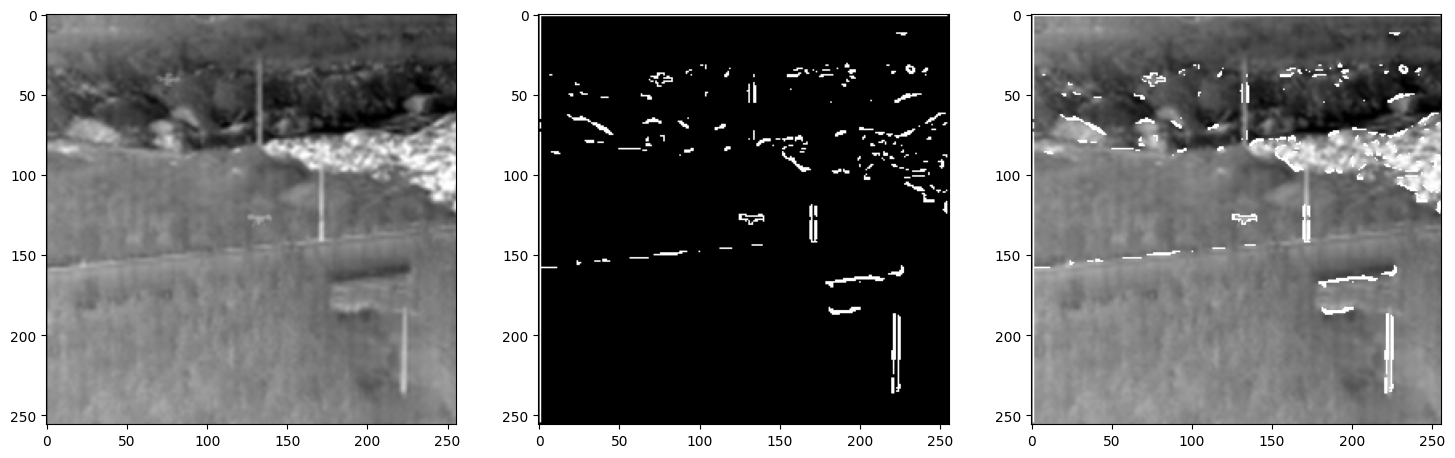

In [32]:
# 显示结果
plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(tensor_image.cpu().squeeze(0), cmap='gray')
plt.subplot(132), plt.imshow(img_gradient.cpu().squeeze(0).squeeze(0), cmap='gray')
synthetic_pict = torch.max(tensor_image.cpu().squeeze(0), img_gradient.cpu().squeeze(0).squeeze(0))
plt.subplot(133), plt.imshow(synthetic_pict, cmap='gray') 
plt.show()

In [8]:
augment_train = transforms.Compose([
            transforms.RandomAffine(degrees=0, translate=(0.8, 0.8)),
            transforms.RandomHorizontalFlip(),  # 随机水平翻转
            # Rotate_4D_Transform(),
        ])

In [9]:
a = torch.randn((2,2,5,5))
print(a)
b = augment_train(a)
print(b.shape)
print(b)

tensor([[[[-0.3254, -0.5944,  0.4050, -0.2986, -1.8631],
          [-1.6440,  0.7701, -1.4835, -0.5865, -0.9571],
          [ 0.0771, -0.2183,  0.5083,  0.1691,  0.1921],
          [ 1.7722,  0.5642, -0.9639,  0.2158,  1.2032],
          [-0.4791,  1.7540,  1.7142,  0.2093, -0.7474]],

         [[ 0.8152,  2.1070, -0.9152, -0.1106, -1.7420],
          [-0.6136,  1.3238,  0.9963, -1.6351,  1.1257],
          [ 1.0182, -1.4833,  0.4142, -0.9592,  2.0406],
          [-1.1099, -2.0986,  0.7513, -0.2791, -0.2663],
          [ 0.5416, -0.3001,  0.7877,  1.7513,  1.5173]]],


        [[[ 0.3279,  0.1472,  0.2154, -1.5667,  0.9296],
          [-0.7428,  1.1201, -1.9077, -0.3763, -1.1109],
          [-0.2556,  0.3891, -1.3611, -1.4847, -0.1226],
          [ 0.5470,  0.4287, -0.8397,  0.3030,  0.3581],
          [-1.3511,  0.7538,  0.3852,  1.5076,  0.0512]],

         [[-0.3533,  0.9713,  0.3085,  0.1644,  0.1535],
          [ 0.5308,  1.4392, -1.7288, -2.5637, -0.6508],
          [ 2.1679, -0.

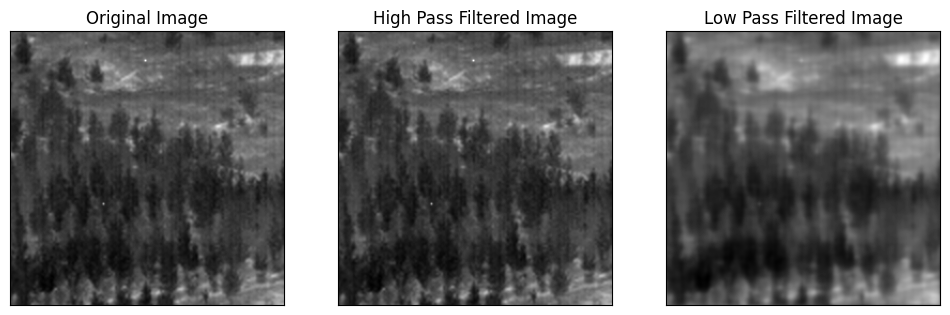

In [26]:
# 读取图像并转换为Tensor
image_path = 'W:/DataSets/ISTD/NUDT-SIRST/trainval/images/000358.png'  # 替换为你的图片路径
image = Image.open(image_path).convert('L')  # 转换为灰度图
transform = transforms.ToTensor()
tensor_image = transform(image)

# 将Tensor转换到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_image = tensor_image.to(device)

# 对图像进行FFT变换
fft_image = torch.fft.fftn(tensor_image, dim=(-2, -1))

# 创建滤波器
def create_filter(shape, cutoff, high_pass=True):
    """ 创建一个高通或低通滤波器 """
    H, W = shape
    x, y = torch.meshgrid(torch.arange(W), torch.arange(H))
    x, y = x - (W // 2), y - (H // 2)
    distance = torch.sqrt(x**2 + y**2)
    filter_ = 1.0 - 1.0 / (1.0 + (cutoff / distance)**(2 * 4))  # Butterworth滤波器
    return filter_ if high_pass else 1.0 - filter_

# 图像尺寸
H, W = fft_image.shape[-2:]

# 设置截止频率
cutoff_high = 300  # 高通滤波器的截止频率
cutoff_low = 400   # 低通滤波器的截止频率

# 创建高通和低通滤波器
high_pass_filter = create_filter((H, W), cutoff_high, high_pass=True).to(device)
low_pass_filter = create_filter((H, W), cutoff_low, high_pass=False).to(device)

# 应用滤波器
filtered_fft_high = fft_image * high_pass_filter
filtered_fft_low = fft_image * low_pass_filter

# 通过逆FFT将频域数据转回空间域
ifft_image_high = torch.fft.ifftn(filtered_fft_high, dim=(-2, -1)).real
ifft_image_low = torch.fft.ifftn(filtered_fft_low, dim=(-2, -1)).real

# 显示结果
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(tensor_image.cpu().squeeze(0), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(ifft_image_high.cpu().squeeze(0), cmap='gray')
plt.title('High Pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(ifft_image_low.cpu().squeeze(0), cmap='gray')
plt.title('Low Pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [3]:
def compute_feature_distance(feature_map, label):
    B, C, S, _ = feature_map.size()
    
    # 创建一个全零的张量来保存结果
    distance_map = torch.zeros(B, 1, S, S, device=feature_map.device)
    
    for b in range(B):
        # 获取当前图像和标签
        img_features = feature_map[b]  # (C, S, S)
        img_label = label[b, 0]  # (S, S)

        # 找到所有的亮点位置
        highlight_indices = torch.nonzero(img_label, as_tuple=True)  # (nonzero_count, 2)
        
        # 如果没有亮点，跳过该图像
        if len(highlight_indices[0]) == 0:
            continue
        
        # 提取亮点位置对应的特征向量
        reference_features = img_features[:, highlight_indices[0], highlight_indices[1]]  # (C, nonzero_count)
        reference_features = reference_features.permute(1, 0)  # (nonzero_count, C)
        
        # 创建一个网格，表示图像中的所有像素点
        grid_y, grid_x = torch.meshgrid(torch.arange(S), torch.arange(S), indexing='ij')
        all_pixel_coords = torch.stack([grid_y.flatten(), grid_x.flatten()], dim=1)  # (S*S, 2)
        
        # 将所有像素点的特征向量展平为 (S*S, C)
        all_pixel_features = img_features.view(C, -1).permute(1, 0)  # (S*S, C)
        
        # 计算所有像素点到所有参考特征向量的距离
        # 使用广播机制来计算距离
        # all_pixel_features: (S*S, C)
        # reference_features: (nonzero_count, C)
        # distances: (S*S, nonzero_count)
        distances = torch.cdist(all_pixel_features, reference_features, p=2)
        
        # 取最小距离
        min_distances, _ = torch.min(distances, dim=1)  # (S*S,)
        
        # 将结果存入 distance_map
        distance_map[b, 0] = min_distances.view(S, S)

    return distance_map

In [ ]:
feature_map = torch.randn((2,2,5,5))
label = (torch.randn((2,1,5,5)) > 1).type(torch.float32)
print(feature_map)
print(label)

In [6]:
dist = compute_feature_distance(feature_map, label) 

In [8]:
print(dist.shape)

torch.Size([2, 1, 5, 5])


In [11]:
torch.max(feature_map)

tensor(2.6439)

In [3]:
a = torch.tensor([0.1, 1., 2., 3.])
b = torch.exp(-a)
print(b)

tensor([0.9048, 0.3679, 0.1353, 0.0498])


In [1]:
import torch

In [22]:
net = torch.nn.Softmax(dim=-1)

def normalize_tensor(tensor):
        """
        对形状为 [B, 1, S] 的张量进行归一化，最后一维张量的最大值为1，最小值为 0。
        
        参数:
        tensor (torch.Tensor): 形状为 [B, 1, S] 的张量
        
        返回:
        torch.Tensor: 归一化后的张量
        """
        # 获取最小值和最大值
        min_vals, _ = tensor.min(dim=-1, keepdim=True)
        max_vals, _ = tensor.max(dim=-1, keepdim=True)
        
        # 防止除零错误
        range_vals = max_vals - min_vals
        range_vals[range_vals == 0] = 1e8  # 如果最大值和最小值相等，设为1避免除零错误
        
        # 归一化
        normalized_tensor = (tensor - min_vals) / range_vals
        
        return normalized_tensor

In [23]:
a = torch.randn((2,1,3,3))
b = a.view(2,1,-1)
# b = torch.where(b <= 0, torch.ones_like(b) * 0.1, b)
print(b)
c = net(b)
print(c)
d = normalize_tensor(c).view(2,1,3,3)
print(d)


tensor([[[ 1.6711,  0.5136,  0.7461, -0.6563, -0.5095,  1.8690, -1.0175,
           0.4137, -1.3416]],

        [[ 0.2213,  1.1739,  0.9487, -1.0707,  0.7321, -0.8448,  0.4355,
          -1.1417,  0.3637]]])
tensor([[[0.2824, 0.0887, 0.1120, 0.0275, 0.0319, 0.3441, 0.0192, 0.0803,
          0.0139]],

        [[0.0944, 0.2447, 0.1953, 0.0259, 0.1573, 0.0325, 0.1169, 0.0242,
          0.1088]]])
tensor([[[[0.8129, 0.2267, 0.2970],
          [0.0414, 0.0546, 1.0000],
          [0.0161, 0.2011, 0.0000]]],


        [[[0.3184, 1.0000, 0.7763],
          [0.0081, 0.6037, 0.0379],
          [0.4207, 0.0000, 0.3839]]]])
